# Analisi dati del CRC
Questo notebook è parzialmente basato sui notebook di Antonio Iuliano: https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/CRCQuality.ipynb?ref_type=heads e https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/DisplayCRCData.ipynb?ref_type=heads

In questa variante, anziché ricostruire "manualmente" le tracce e le coordinate angolari, utilizziamo direttamente i valori forniti dall'ultima versione dell'app (v 2.10) 

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.modeling import models, fitting

In [2]:
data_file = "./data/CRC-4 LNGS 28-04-2025 21-51-35.txt"
crc_ver = '2.10'

## Lettura dei dati
cf. https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/CRCQuality.ipynb?ref_type=heads

In [3]:
def convertdata(xnumber,verbose = False):
 '''converte i dati dal CRC in binario, con l'informazione dei piani accesi
    xnumber: numero del piano;
    verbose: se True, stampa a schermo i numeri convertiti per controllo
 '''
 nplanes = 4
 planes=[] #lista di destinazione
 for iplane in range(nplanes-1,-1,-1): #ciclo da 3 a 0
  #convertiamo i numeri da esadecimale, per ognuno dei 4 piani
  planecode = int(xnumber[2*iplane:2*iplane+2],16)
  if (verbose):
   #stampiamo le informazioni dei piani
   print(format(planecode,"#08b")) #08b è il formato binario, con gli zeri a monte lasciati per vedere i piani spenti
  planes.append(format(planecode,"#08b")) #aggiungiamo il piano alla lista di uscita
 return planes 

In [4]:
muondata = pd.read_csv(data_file,header=None,sep=" ",dtype=str)
if crc_ver == '2.4':
    muondata.columns = ["Event Number","YZview","XZview","Time"] #first Y, then X
elif crc_ver == '2.10':
    ### NB: Usare la linea seguente per i dati acquisiti con l'app >=v2.10
    muondata.columns = ["Event Number","XZview","YZview","Date","Time","AM/PM","Meta"]

muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°"
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°"
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°"
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°"
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°"


In [5]:
# Some rows have bad data (less than 8 hex digits)
quality_selection = np.bitwise_and([len(str(x))==8 for x in muondata["XZview"]], [len(str(x))==8 for x in muondata["YZview"]])
print('Length before quality selection:', len(muondata))
muondata = muondata[quality_selection]
print('Length after quality selection:', len(muondata))

Length before quality selection: 48956
Length after quality selection: 48949


In [6]:
muondata["XZdecoded"]=muondata["XZview"].apply(convertdata)
muondata["YZdecoded"]=muondata["YZview"].apply(convertdata)
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°","[0b001000, 0b000100, 0b000010, 0b000001]","[0b001000, 0b000100, 0b000100, 0b000010]"
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°","[0b000001, 0b000001, 0b000010, 0b000010]","[0b010000, 0b010000, 0b100000, 0b100000]"
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°","[0b011000, 0b001000, 0b011000, 0b001000]","[0b001001, 0b001010, 0b111100, 0b101000]"
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°","[0b000010, 0b000100, 0b001000, 0b001000]","[0b000010, 0b000100, 0b010000, 0b100000]"
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°","[0b001000, 0b001000, 0b001000, 0b000100]","[0b000010, 0b000010, 0b000010, 0b000010]"


In [7]:
def get_ctheta_phi(meta_string):
    contents = meta_string.split(';')
    ctheta = contents[-2].replace(',', '.')
    phi_deg = contents[-1].strip("°")
    return float(ctheta), float(phi_deg)

In [8]:
muondata[["cos theta", "phi"]] = muondata.apply(
    lambda row: get_ctheta_phi(row["Meta"]),
    axis=1,
    result_type='expand'
)
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded,cos theta,phi
0,4088,01020408,02040408,28/4/2025,09:51:35.032,PM,"_;_;_;_;_;0,8638684;300°","[0b001000, 0b000100, 0b000010, 0b000001]","[0b001000, 0b000100, 0b000100, 0b000010]",0.863868,300.0
1,4089,02020101,20201010,28/4/2025,09:51:35.207,PM,"_;_;_;_;_;0,9622505;135°","[0b000001, 0b000001, 0b000010, 0b000010]","[0b010000, 0b010000, 0b100000, 0b100000]",0.962251,135.0
2,4090,08180818,283C0A09,28/4/2025,09:51:35.614,PM,"_;_;_;_;_;0,9050967;183°","[0b011000, 0b001000, 0b011000, 0b001000]","[0b001001, 0b001010, 0b111100, 0b101000]",0.905097,183.0
3,4091,08080402,20100402,28/4/2025,09:51:35.859,PM,"_;_;_;_;_;0,7874992;153°","[0b000010, 0b000100, 0b001000, 0b001000]","[0b000010, 0b000100, 0b010000, 0b100000]",0.787499,153.0
4,4092,04080808,02020202,28/4/2025,09:51:36.080,PM,"_;_;_;_;_;0,9889364;270°","[0b001000, 0b001000, 0b001000, 0b000100]","[0b000010, 0b000010, 0b000010, 0b000010]",0.988936,270.0


## Controllo della qualità dei dati
Filtriamo i dati imponendo che sia verificata una di queste condizioni:
* Ogni piano ha un solo canale acceso (e.g. `0b001000`)
* Ogni piano ha al massimo due bit adiacenti accesi (e.g. `0b011000`)

Gli altri eventi vengono scartati.

In [25]:
size_before_qc = len(muondata)

In [26]:
# Credit: ChatGPT
def is_valid(planes):
    for x in planes:
        # Count the number of 1s
        ones = x.count('1')
        if ones > 2:
            return False
        elif ones == 2:
            # Check if the two 1s are adjacent
            if '11' not in x:
                return False
    # If no False has been returned yet, return True
    return True

In [27]:
# Filter rows where both columns satisfy the condition
mask = muondata.apply(lambda row: is_valid(row['XZdecoded']) and is_valid(row['YZdecoded']), axis=1)

In [28]:
muondata = muondata[mask]

In [29]:
size_after_qc = len(muondata)
print(f"Il numero di eventi è stato ridotto da {size_before_qc} a {size_after_qc}.")
print(f"Sono stati rimossi {size_before_qc-size_after_qc} eventi ({(size_before_qc-size_after_qc)/size_before_qc*100:.2f}%).")

Il numero di eventi è stato ridotto da 48949 a 44663.
Sono stati rimossi 4286 eventi (8.76%).


## Calcolo della distribuzione angolare
A questo punto possiamo realizzare degli istogrammi degli eventi in funzione di $\theta$ e $\phi$.

In [9]:
n_bins = 5
counts, ctheta_bins, phi_bins = np.histogram2d(muondata["cos theta"], muondata["phi"], bins=n_bins)

In [10]:
counts

array([[  60.,   57.,   11.,   44.,   44.],
       [ 614.,  519.,  527.,  405.,  481.],
       [1309., 1342., 1653., 1250., 1007.],
       [2772., 2468., 3114., 2503., 1985.],
       [8362., 5452., 4926., 4887., 3157.]])

In [11]:
ctheta_bins

array([0.6395294 , 0.71162352, 0.78371764, 0.85581176, 0.92790588,
       1.        ])

Text(0, 0.5, 'Counts')

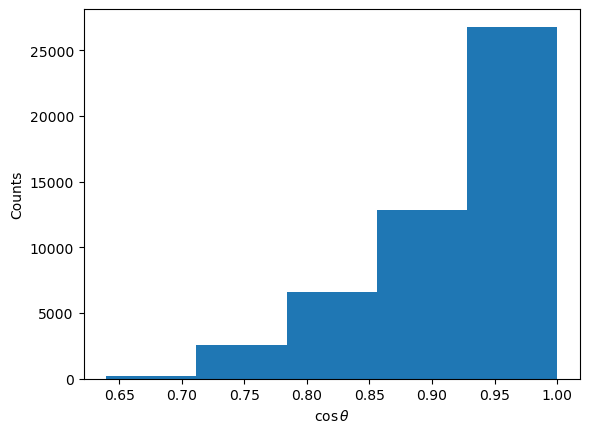

In [12]:
# Plot theta histogram
plt.hist(muondata["cos theta"], ctheta_bins)
plt.xlabel(r'$\cos\theta$')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

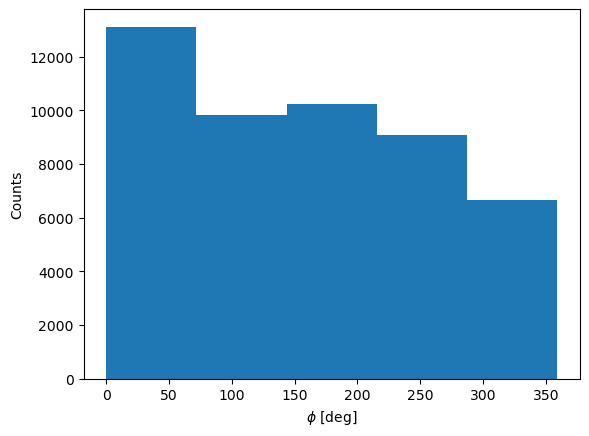

In [13]:
# Plot phi histogram
plt.hist(muondata["phi"], phi_bins)
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

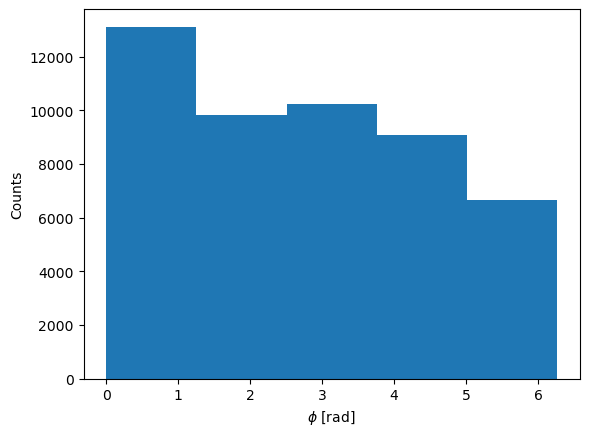

In [14]:
plt.hist(np.deg2rad(muondata["phi"]), np.deg2rad(phi_bins))
plt.xlabel(r'$\phi$ [rad]')
plt.ylabel('Counts')

Text(0, 0.5, '$\\phi$ [deg]')

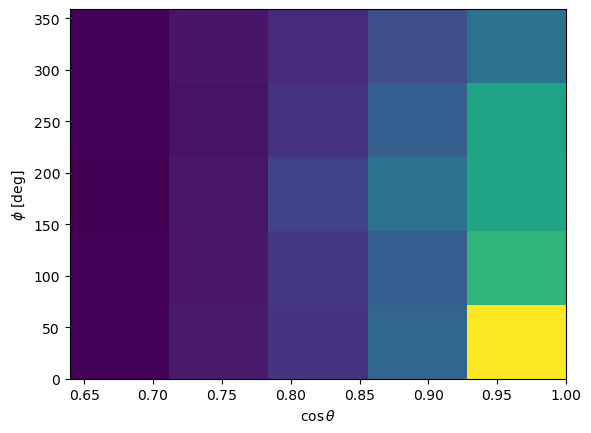

In [15]:
plt.hist2d(muondata["cos theta"], muondata["phi"], bins=n_bins)
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\phi$ [deg]')


## Calcolo del flusso angolare
Seguiamo la formula
$$
    \Phi(\theta,\phi)=\frac{N(\theta,\phi)}{T_{\rm obs}A_{\rm eff}(\theta,\phi)\Delta\Omega}
$$
dove $N$ è il numero di conteggi, $T_{\rm obs}$ è il tempo di osservazione, $A_{\rm eff}$ è l'area efficace (vedere il notebook dedicato) e $\Delta\Omega=\Delta\cos\theta\Delta\phi$ è l'elemento di angolo solido considerato. Assumendo un errore poissoniano sui conteggi, l'errore sul flusso sarà dato da
$$
    \Delta\Phi(\theta,\phi)=\frac{\sqrt{N(\theta,\phi)}}{T_{\rm obs}A_{\rm eff}(\theta,\phi)\Delta\Omega}
$$

Calcoliamo ora il flusso in bin di $\phi$ e $\cos\theta$:

In [37]:
dctheta = np.diff(ctheta_bins)[0]
dphi = np.diff(np.deg2rad(phi_bins))[0]
ctheta_center = ctheta_bins[:-1] + dctheta/2
phi_center = np.deg2rad(phi_bins[:-1]) + dphi/2

In [38]:
domega = dctheta*dphi

Calcoliamo il tempo di osservazione dalla tabella dei dati:

In [39]:
datetimes = [datetime.strptime(d+' '+t+' '+ p, '%d/%m/%Y %I:%M:%S.%f %p') for (d,t,p) in zip(muondata["Date"], muondata["Time"], muondata["AM/PM"])]
t = (max(datetimes) - min(datetimes)).total_seconds()
print('Tempo di osservazione:', t, 's', f'({t/3600.:.2f} h)')

Tempo di osservazione: 35770.767 s (9.94 h)


Per l'area efficace, definiamo la funzione apposita, specificando le dimensioni del cubo e il numero dei piani di trigger.  Ricordiamo che le barre di scintillatore sono larghe 4 cm, lunghe 26 cm e spesse 1 cm. I moduli sono costituiti da due strati di barrette sovrapposte ortogonalmente e separati verticalmente di 7 cm. (https://web.infn.it/OCRA/misura-della-rate-di-muoni-cosmici/)

In [40]:
L = 24
dz = 7
n = 4
def aeff(L, n, dz, theta, phi):
    # Fold phi in [0, pi/4] range
    if phi < 0 or phi > np.pi/4:
        phi_original = phi
        phi = phi % (np.pi/2)             # Wrap into [0, pi/2]
        phi = min(phi, np.pi/2 - phi)     # Fold into [0, pi/4]
        
    # Check if theta < theta_max
    if n == 1:
        th_max = np.pi/2
    else:
        th_max = np.arctan(L/((n-1)*dz*np.cos(phi)))
    if theta > th_max:
        raise ValueError(f'theta = {theta} > {th_max} for phi = {phi}')

    # If no errors, compute and return effective area
    term_1 = (L**2/np.cos(phi) - (n-1)*L*dz*np.tan(theta))*(1-np.tan(phi))
    term_2 = (L**2/np.cos(phi)**2 + (n-1)**2*dz**2*np.tan(theta)**2 - 2*(n-1)/np.cos(phi)*L*dz*np.tan(theta))*np.sin(phi)
    a = (term_1 + term_2)*np.cos(phi)*np.cos(theta)
    return a

**Nota:** 

Il calcolo dell'area efficace (v. `effective_area.ipynb`) è stato effettuato considerando un rivelatore con piani di spessore nullo separati da una distanza $\Delta z$, da cui dipende il massimo valore di $\theta$ per cui l'area efficace si annulla. Tuttavia, come è facilmente intuibile, nel caso in cui lo spessore dei piani non sia trascurabile questo valore massimo cambia ed è leggermente maggiore rispetto a quello calcolato nel caso di spessore nullo. Da questo fatto segue che se si prova a usare lo stesso valore di $\Delta z$ per ricostruire le tracce (considerando lo spessore dei piani) e per calcolare l'area efficace, ci possono essere alcuni valori ricostruiti di $\theta$ superiori al massimo teorico, che danno luogo a valori dell'area efficace negativi o comunque errati. 

In primissima approssimazione si può aggirare questo problema considerando un $\Delta z$ leggermente inferiore nel calcolo dell'area efficace. In questo modo i valori di $\theta$ vengono ricostruiti abbastanza correttamente (confrontare i valori dei coseni con quelli riportati dall'app...), e quelli più "estremi" vengono inclusi considerando un rivelatore con un'accettanza leggermente superiore a quella prevista teoricamente.

 Abbiamo quindi tutti gli elementi per calcolare il flusso in funzione di $\theta$ e $\phi$:

In [41]:
flux = np.array([[None for _ in ctheta_center] for _ in phi_center])
dflux = np.array([[None for _ in ctheta_center] for _ in phi_center])

In [42]:
for (i,cth) in enumerate(ctheta_center):
    for (j,ph) in enumerate(phi_center):
        th = np.acos(cth)
        a = aeff(L, n, dz, th, ph)
        flux[i,j] = counts[i,j]/(t*a*domega)
        dflux[i,j] = np.sqrt(counts[i,j])/(t*a*domega)

Calcoliamo quindi il flusso integrato su $\phi$, in modo tale da ottenere la dipendenza da $\theta$. Con un abuso di notazione definiamo
$$
    \Phi(\theta)=\int_{-\pi}^{\pi}\Phi(\theta,\phi)\,{\rm d}\phi=\sum_i\Phi(\theta,\phi_i)\Delta\phi
$$
L'errore si ottiene dalla somma in quadratura:
$$
    \Delta\Phi(\theta)=\sqrt{\sum_i\left(\Delta\Phi(\theta,\phi_i)\Delta\phi\right)^2}
$$

In [44]:
flux_theta = np.sum(flux, axis=1)*dphi
dflux_theta = [np.sqrt(x)*dphi for x in np.sum(dflux**2, axis=1)]

Per finire, adattiamo una funzione del tipo $p_0+p_1\cos^2\theta$ ai valori misurati di $\Phi(\theta)$: 

In [27]:
from scipy.optimize import curve_fit
def model(ctheta, p0, p1):
    return p0 + p1 * ctheta**2

popt, pcov = curve_fit(model, ctheta_center, flux_theta, sigma=dflux_theta)
p0, p1 = popt

ctheta_fit = np.linspace(0, 1, 1000)
y_fit = model(ctheta_fit, *popt)

In [28]:
print('p0:', p0, '\np1', p1)

p0: -0.014879306021908444 
p1 0.04188783637923978


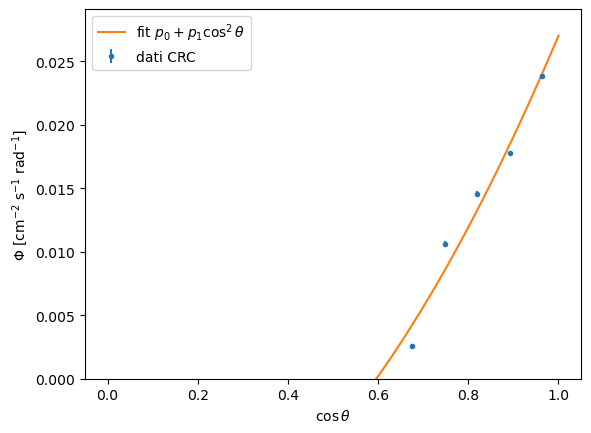

In [29]:
plt.errorbar(ctheta_center, flux_theta, yerr=dflux_theta, marker='.', label='dati CRC', linestyle='none')
plt.plot(ctheta_fit, y_fit, label=r'fit $p_0 + p_1\cos^2\theta$')
plt.xlabel(r'$\cos\theta$')
plt.ylabel(r'$\Phi$ [cm$^{-2}$ s$^{-1}$ rad$^{-1}$]')
plt.ylim(bottom=0)
plt.legend()

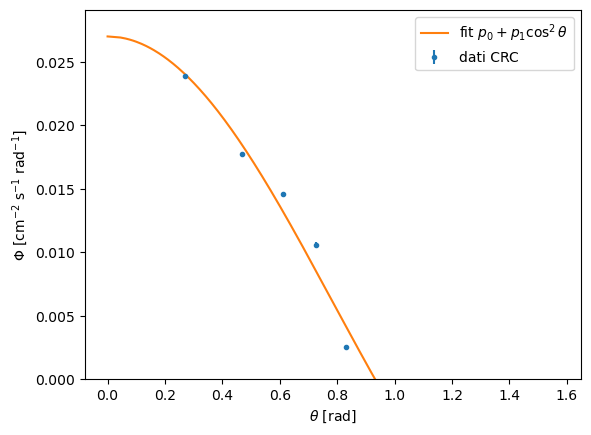

In [30]:
plt.errorbar(np.acos(ctheta_center), flux_theta, yerr=dflux_theta, marker='.', label='dati CRC', linestyle='none')
plt.plot(np.acos(ctheta_fit), p0 + p1*ctheta_fit**2, label=r'fit $p_0 + p_1\cos^2\theta$')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\Phi$ [cm$^{-2}$ s$^{-1}$ rad$^{-1}$]')
plt.ylim(bottom=0)
plt.legend()